In [1]:
import h5py    
import numpy as np    
import pandas as pd
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
from astropy import constants as const

yrsec = (1*u.yr).to(u.s).value # 1 year in secs
solar_mass = const.M_sun.value #in Kgs

#hubble_time = (1/cosmo.H(0)).to(u.yr).value #Hubble time = 1/H0 
age_of_the_universe = cosmo.age(0).to(u.yr).value


#parent folder
pfolder = "/Users/pranavsatheesh/Triples/Github/"
import sys
sys.path.append(pfolder)

#binary merger files 
file_name = pfolder + "Illustris_Data/mbhb-evolution_no-ecc_lc-full-0.6.hdf5"
f1 = h5py.File(file_name,'r') 

Ms = np.array(f1['evolution']['masses'])
t = np.array(f1['evolution']['times'])
r = np.array(f1['evolution']['sep'])


Ms = Ms/(solar_mass*10**3) #Ms is in gm
Nbinary = len(Ms) #Number of binaries 
M1 = Ms[:,0]
M2 = Ms[:,1]


# the merger is the maximum value in each time evolution of the binary
t_bin_merger = np.amax(t,1)/yrsec
# t_list = []
# for i in range(Nbinary):
#     t_list.append(t[i][np.argwhere(r[i]==0)[0][0]]) 

merger = [] #to indicate if the binary actually merges before hubble time
z_binary = []

for time in t_bin_merger:
    if time >= age_of_the_universe:
        #these black holes aren't merging
        merger.append("No")
        z_binary.append(0)
    else:
        merger.append("Yes")
        z_binary.append(z_at_value(cosmo.age,(time/10**9)*u.Gyr,zmin=1e-9).value)

binary_df = pd.DataFrame([M1,M2,t_bin_merger,merger,z_binary])
binary_df = binary_df.transpose()
binary_df.columns = ['M1', 'M2', 't_merger','Merger','Redshift']


#binary ids
mergers = np.load(pfolder+'Illustris_Data/ill-1_blackhole_mergers_fixed.npz')
indexes = f1['evolution']['val_inds'][:]
binary_ids = mergers['ids'][indexes]

Triple_df = pd.read_csv(pfolder+"Illustris_Data/triple_data_ill.csv") #the triples data file from find_triples.py

#Black hole IDs of all the triples
bh1id1 = Triple_df["bhid1_bin_1"].to_numpy()
bh1id2 = Triple_df["bhid2_bin_1"].to_numpy()
bh2id1 = Triple_df["bhid1_bin_2"].to_numpy()
bh2id2 = Triple_df["bhid2_bin_2"].to_numpy()

def searchID(id):
    #to search if the binary ids belong to any triples, indicating a triple interaction

    tf1 = id in bh1id1
    tf2 = id in bh1id2
    tf3 = id in bh2id1
    tf4 = id in bh2id2

    tf = tf1 + tf2 + tf3 + tf4

    return tf 

merger_type = [] #"iso" for binaries that undergo isolated evolution. "trip" for the ones that have some kind of triple interaction"

for i in range(Nbinary):

    search1 = searchID(binary_ids[i][0])
    search2 = searchID(binary_ids[i][1])

    search = search1 + search2
    if(search == 0):
        merger_type.append("iso")
    else:
        merger_type.append("trip")
       

binary_df["Type"] = merger_type


binary_ids = np.array(binary_ids)
binary_df["BH1-ID"] = binary_ids[:,0]
binary_df["BH2-ID"] = binary_ids[:,1]

print("Number of Binaries: %d"%(len(binary_df)))
print("Number of merged binaries: %d"%(len(binary_df[binary_df["Merger"]=="Yes"])))
print("Number of Isolated Binary mergers: %d"%(len(binary_df[(binary_df["Merger"]=="Yes") & (binary_df["Type"] == "iso")])))
print("Number of Binaries with triple influence: %d"%(len(binary_df[(binary_df["Type"] == "trip")])))
print("Number of Binary non mergers with triple influence: %d"%(len(binary_df[(binary_df["Merger"]=="No") & (binary_df["Type"] == "trip")])))

binary_file_loc = "Data/binary-merger-data.csv"
binary_df.to_csv(binary_file_loc,index = False)
print("Binary file saved at %s"%(binary_file_loc))

Ntriple = np.size(bh1id1) #Number of triples

Number of Binaries: 9234
Number of merged binaries: 2370
Number of Isolated Binary mergers: 1929
Number of Binaries with triple influence: 1401
Number of Binary non mergers with triple influence: 960
Binary file saved at Data/binary-merger-data.csv


In [14]:
dM_value = []
qout_value = []

In [17]:
m1_list = []
m1_id = []
m2_list = []
m2_id = []
m3_list = []
m3_id = []

for i in range(Ntriple):

    m1 = Triple_df["M1_bin_1"].iloc[i]
    m2 = Triple_df["M2_bin_1"].iloc[i]

    qin_old = m2/m1

    if((bh1id1[i]==bh2id1[i])|(bh1id2[i]==bh2id1[i])):
        m3 = Triple_df["M2_bin_2"].iloc[i]
        mA = Triple_df["M1_bin_2"].iloc[i]

    elif((bh1id1[i]==bh2id2[i])|(bh1id2[i]==bh2id2[i])):
        m3 = Triple_df["M1_bin_2"].iloc[i]
        mA = Triple_df["M2_bin_2"].iloc[i]
    
    dM = mA-(m1+m2)
    dM_value.append(dM)
    qout = m3/(m1+m2)
    qout_value.append(qout)

Text(0.5, 0, '$log(|\\Delta M|/M_{\\odot})$')

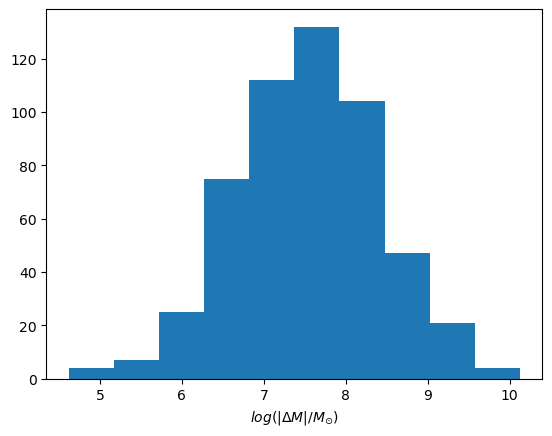

In [29]:
plt.hist(np.log10(np.abs(dM_value)))
plt.xlabel("$log(|\Delta M|/M_{\odot})$")

(array([  3.,   4.,  21.,  21.,  30.,  46., 273., 103.,  23.,   7.]),
 array([-2.66587513, -2.24641949, -1.82696384, -1.4075082 , -0.98805255,
        -0.5685969 , -0.14914126,  0.27031439,  0.68977003,  1.10922568,
         1.52868132]),
 <BarContainer object of 10 artists>)

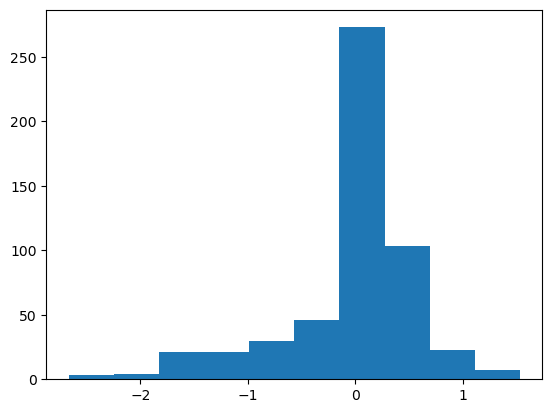

In [20]:
plt.hist(np.log10(qout_value))

In [7]:
m1_list = []
m1_id = []
m2_list = []
m2_id = []
m3_list = []
m3_id = []

ix_remove = []

for i in range(Ntriple):

    m1 = Triple_df["M1_bin_1"].iloc[i]
    m2 = Triple_df["M2_bin_1"].iloc[i]
    
    qin_old = m2/m1

    mA = Triple_df["M1_bin_2"].iloc[i]
    m3 = Triple_df["M2_bin_2"].iloc[i]

    dM = mA-(m1+m2)

    if(dM>0):
        dM_value.append(dM)
        m1_new = m1 + dM*(1-qin_old)
        m2_new = m2 + dM*qin_old

        if (m1_new>m2_new):
            m1_list.append(m1_new)
            m1_id.append(Triple_df["bhid1_bin_1"].iloc[i])
            m2_list.append(m2_new)
            m2_id.append(Triple_df["bhid2_bin_1"].iloc[i])
        
        else:
            m1_list.append(m2_new)
            m1_id.append(Triple_df["bhid2_bin_1"].iloc[i])
            m2_list.append(m1_new)
            m2_id.append(Triple_df["bhid1_bin_1"].iloc[i])
        
        m3_list.append(m3)
        m3_id.append(Triple_df["bhid1_bin_2"].iloc[i])

    else:
        ix_remove.append(i)
        


m1_list = np.array(m1_list)
m2_list = np.array(m2_list)
m3_list = np.array(m3_list)

m1_id = np.array(m1_id)
m2_id = np.array(m2_id)
m3_id = np.array(m3_id)

M1 = m1_list
qin = m2_list/m1_list
qout = m3_list/(m1_list + m2_list)

Text(0.5, 0, '$log(\\Delta M/M_{\\odot})$')

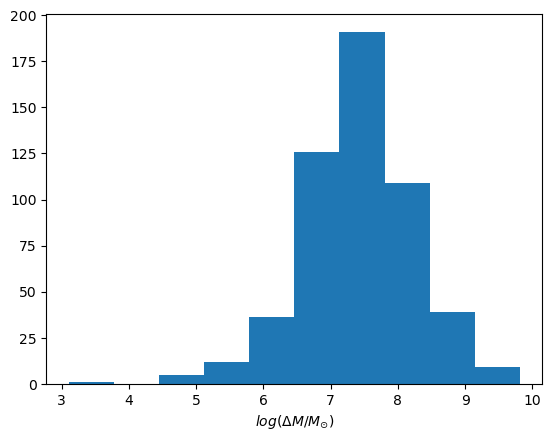

In [13]:
import matplotlib.pyplot as plt
plt.hist(np.log10(dM_value))
plt.xlabel("$log(\Delta M/M_{\odot})$")